<a href="https://colab.research.google.com/github/alwaysneedhelp/AI-Challenge/blob/main/AI_Challenge_1(2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***Load Data and Import Needed Libraries***

In [231]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
from scipy.stats import randint, uniform
from xgboost import XGBClassifier
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [232]:
df = pd.read_csv('/content/drive/MyDrive/AI_Challenge_1_train.csv')
orig_df = df
for name in df.columns:
  df[name] = df[name].apply(
      lambda x: "No" if str(x).startswith("No") else x
  )


# ***Preprocess data***

In [233]:
def preprocess(df):
  def filling_missed(df):
    df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
    df['TotalCharges'] = df['TotalCharges'].fillna(df['TotalCharges'].median())
    import numpy as np

    df = df.replace(r'^\s*$', np.nan, regex=True)
    num_cols = df.select_dtypes(include=np.number).columns
    df[num_cols] = df[num_cols].fillna(df[num_cols].median())

    cat_cols = df.select_dtypes(include='object').columns
    df[cat_cols] = df[cat_cols].apply(lambda col: col.fillna(col.mode()[0]))

    return df


  def classifying(df):
    classing = [x for x in df.columns if df[x].dtype == object]
    for each in classing:
      if each in df.columns:
        df[each] = df[each].astype('category').cat.codes
    return df


  def new_features(df):

    df["Internet_OnlineSec_code"] = pd.factorize(
        df["InternetService"].astype(str) + "_" + df["OnlineSecurity"].astype(str)
    )[0]
    df['Electronic_check'] = (df['PaymentMethod']==2).astype(int)

    df['is_new'] = (df['tenure']<6).astype(int)

    return df

  df = new_features(classifying(filling_missed(df)))

  return df


df = preprocess(df)


In [234]:
df.columns

Index(['id', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'PaperlessBilling', 'PaymentMethod',
       'MonthlyCharges', 'TotalCharges', 'Churn', 'Internet_OnlineSec_code',
       'Electronic_check', 'is_new'],
      dtype='object')

In [235]:
df

,id,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,StreamingTV,StreamingMovies,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,Internet_OnlineSec_code,Electronic_check,is_new
0,1162,1,0,0,1,1,0,0,0,0,...,0,0,1,3,31.35,31.35,1,0,0,1
1,2143,0,0,0,1,21,1,0,0,1,...,0,1,0,3,64.85,1336.80,0,1,0,0
2,1624,0,0,0,0,54,1,1,1,0,...,1,1,1,0,97.20,5129.45,0,2,0,0
3,6075,1,0,1,0,1,0,0,0,0,...,0,0,1,2,23.45,23.45,1,0,1,1
4,1363,1,0,0,0,4,1,0,1,0,...,0,0,1,2,70.20,237.95,1,2,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5630,3773,1,0,1,0,1,1,0,1,1,...,1,1,1,2,95.00,95.00,1,4,1,1
5631,5192,0,0,1,1,23,1,1,0,1,...,1,1,1,1,91.10,2198.30,0,1,0,0
5632,5227,1,0,1,1,12,1,0,2,0,...,0,0,1,2,21.15,306.05,0,3,1,0
5633,5391,1,1,0,0,12,1,1,1,0,...,1,1,1,2,99.45,1200.15,1,2,1,0


# ***Visualization***

In [236]:
orig_df

,id,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,1162,Male,0,No,Yes,1,No,No,DSL,No,Yes,No,No,No,No,Yes,Mailed check,31.35,31.35,Yes
1,2143,Female,0,No,Yes,21,Yes,No,DSL,Yes,No,Yes,No,No,Yes,No,Mailed check,64.85,1336.80,No
2,1624,Female,0,No,No,54,Yes,Yes,Fiber optic,No,Yes,No,No,Yes,Yes,Yes,Bank transfer (automatic),97.20,5129.45,No
3,6075,Male,0,Yes,No,1,No,No,DSL,No,No,No,No,No,No,Yes,Electronic check,23.45,23.45,Yes
4,1363,Male,0,No,No,4,Yes,No,Fiber optic,No,No,No,No,No,No,Yes,Electronic check,70.20,237.95,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5630,3773,Male,0,Yes,No,1,Yes,No,Fiber optic,Yes,No,No,No,Yes,Yes,Yes,Electronic check,95.00,95.00,Yes
5631,5192,Female,0,Yes,Yes,23,Yes,Yes,DSL,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Credit card (automatic),91.10,2198.30,No
5632,5227,Male,0,Yes,Yes,12,Yes,No,No,No,No,No,No,No,No,Yes,Electronic check,21.15,306.05,No
5633,5391,Male,1,No,No,12,Yes,Yes,Fiber optic,No,No,Yes,No,Yes,Yes,Yes,Electronic check,99.45,1200.15,Yes


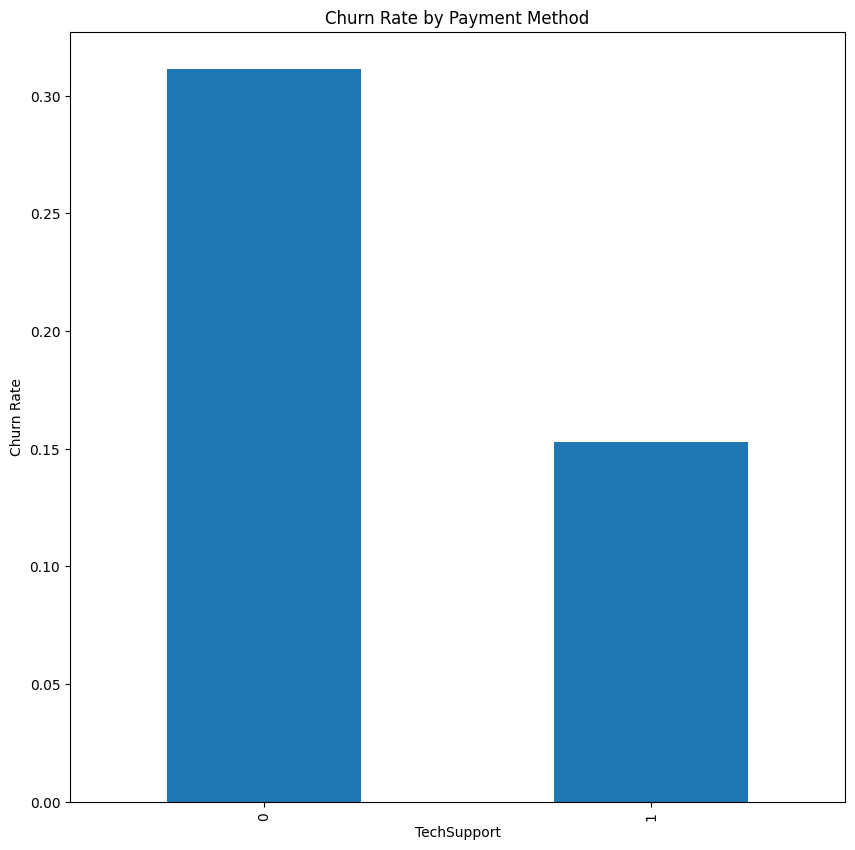

In [237]:
# group by OnlineSecurity and calculate churn rate
churn_rate = df.groupby("TechSupport")["Churn"].mean()

plt.figure(figsize=(10, 10))

churn_rate.plot(kind="bar")
plt.ylabel("Churn Rate")
plt.title("Churn Rate by Payment Method")
plt.show()

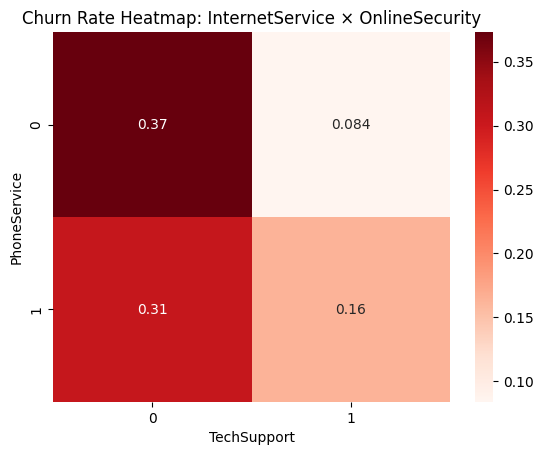

In [238]:
import seaborn as sns

pivot = df.pivot_table(values="Churn",
                       index="PhoneService",
                       columns="TechSupport",
                       aggfunc="mean")

sns.heatmap(pivot, annot=True, cmap="Reds")
plt.title("Churn Rate Heatmap: InternetService × OnlineSecurity")
plt.show()

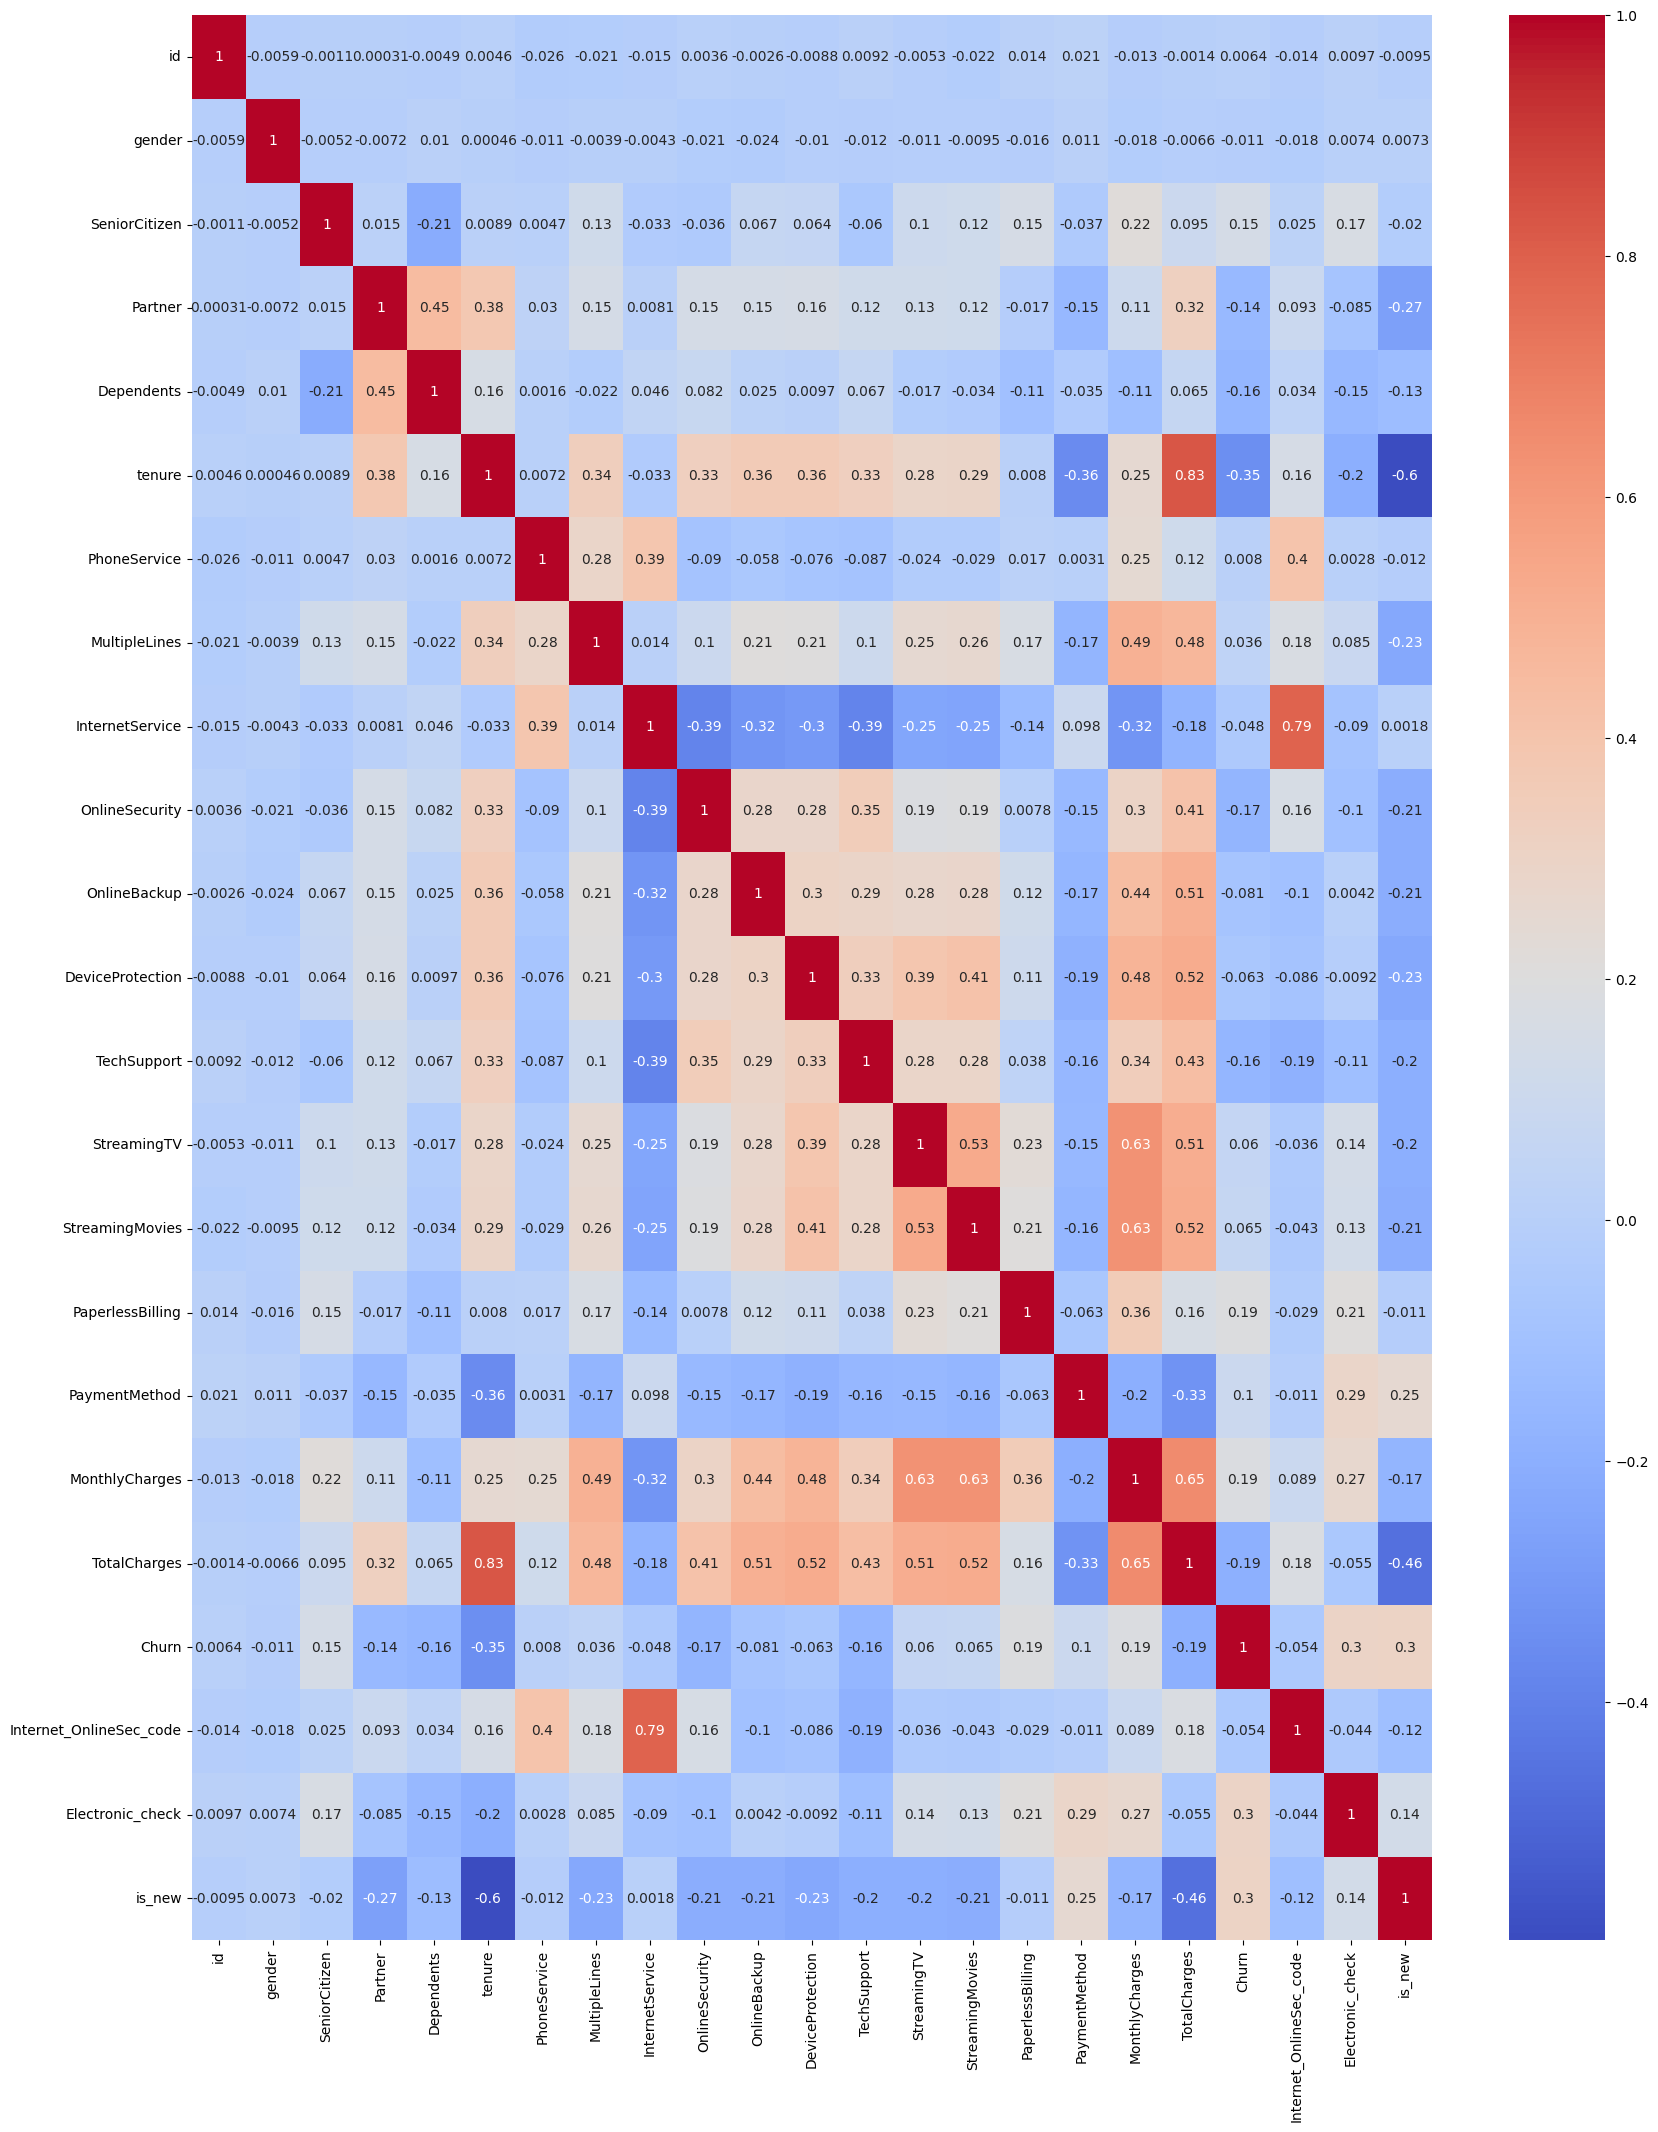

In [239]:
plt.figure(figsize=(20,25))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.show()

# ***Train the model***

In [240]:
X = df.drop('Churn', axis=1)
y = df['Churn']
#x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
x_train = X
y_train = y

In [ ]:
xgb = XGBClassifier(
    objective="binary:logistic",
    tree_method="hist",      # or "gpu_hist" if you have a GPU
    eval_metric="auc",
    n_estimators=2000,       # large; we'll use early stopping
    n_jobs=-1,
    random_state=42
)

param_dist = {
    "max_depth": randint(3, 9),
    "learning_rate": uniform(0.01, 0.15),
    "min_child_weight": randint(1, 8),
    "subsample": uniform(0.6, 0.4),
    "colsample_bytree": uniform(0.6, 0.4),
    "gamma": uniform(0.0, 0.4),
    "reg_lambda": uniform(0.5, 2.5),
    "reg_alpha": uniform(0.0, 0.6)
}

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

search = RandomizedSearchCV(
    xgb,
    param_distributions=param_dist,
    n_iter=60,
    scoring="roc_auc",
    cv=cv,
    verbose=1,
    n_jobs=-1,
)

search.fit(x_train, y_train,
           verbose=False)

print("Best weighted-F1 (CV):", search.best_score_)
print("Best params:", search.best_params_)

best_model = search.best_estimator_

<Axes: title={'center': 'Feature importance'}, xlabel='Importance score', ylabel='Features'>

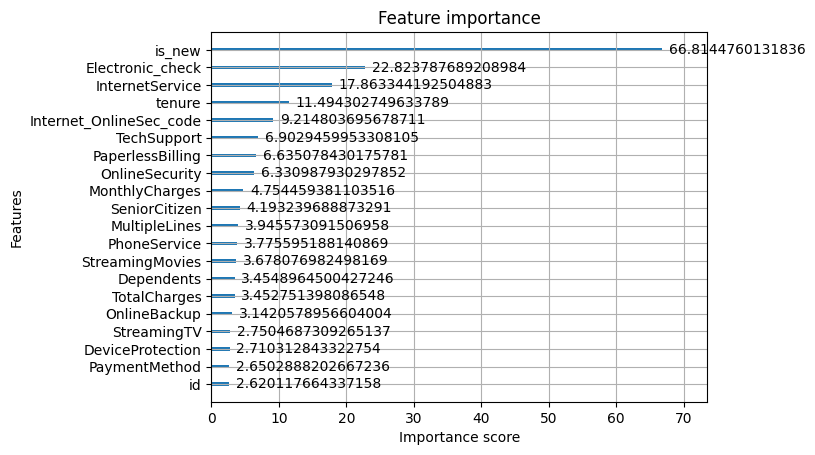

In [244]:
from xgboost import plot_importance

importances = best_model.get_booster().get_score(importance_type="weight")

# As a plot
plot_importance(best_model, importance_type="gain", max_num_features=20)


# ***Get Output***

In [248]:
test_df = pd.read_csv('/content/drive/MyDrive/AI_Challenge_1_test.csv')

test_df = preprocess(test_df)
final_pred = best_model.predict(test_df)

In [249]:
results = pd.DataFrame({
    "id": test_df["id"],   # or df['id'] if you have an 'id' column
    "Churn": pd.Series(final_pred).map({1: "Yes", 0: "No"})
})

name = 'new.csv'

results.to_csv(name, index=False)
print(f"Saved to {name}")

Saved to new.csv
